<a href="https://colab.research.google.com/github/WHY210/Applications-of-AI-in-Project-Management/blob/main/%5B%20FINAL%20PRESENTATION%20%5D%20Forecasting%20CCI%20in%20Taiwan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download / Import : Library + 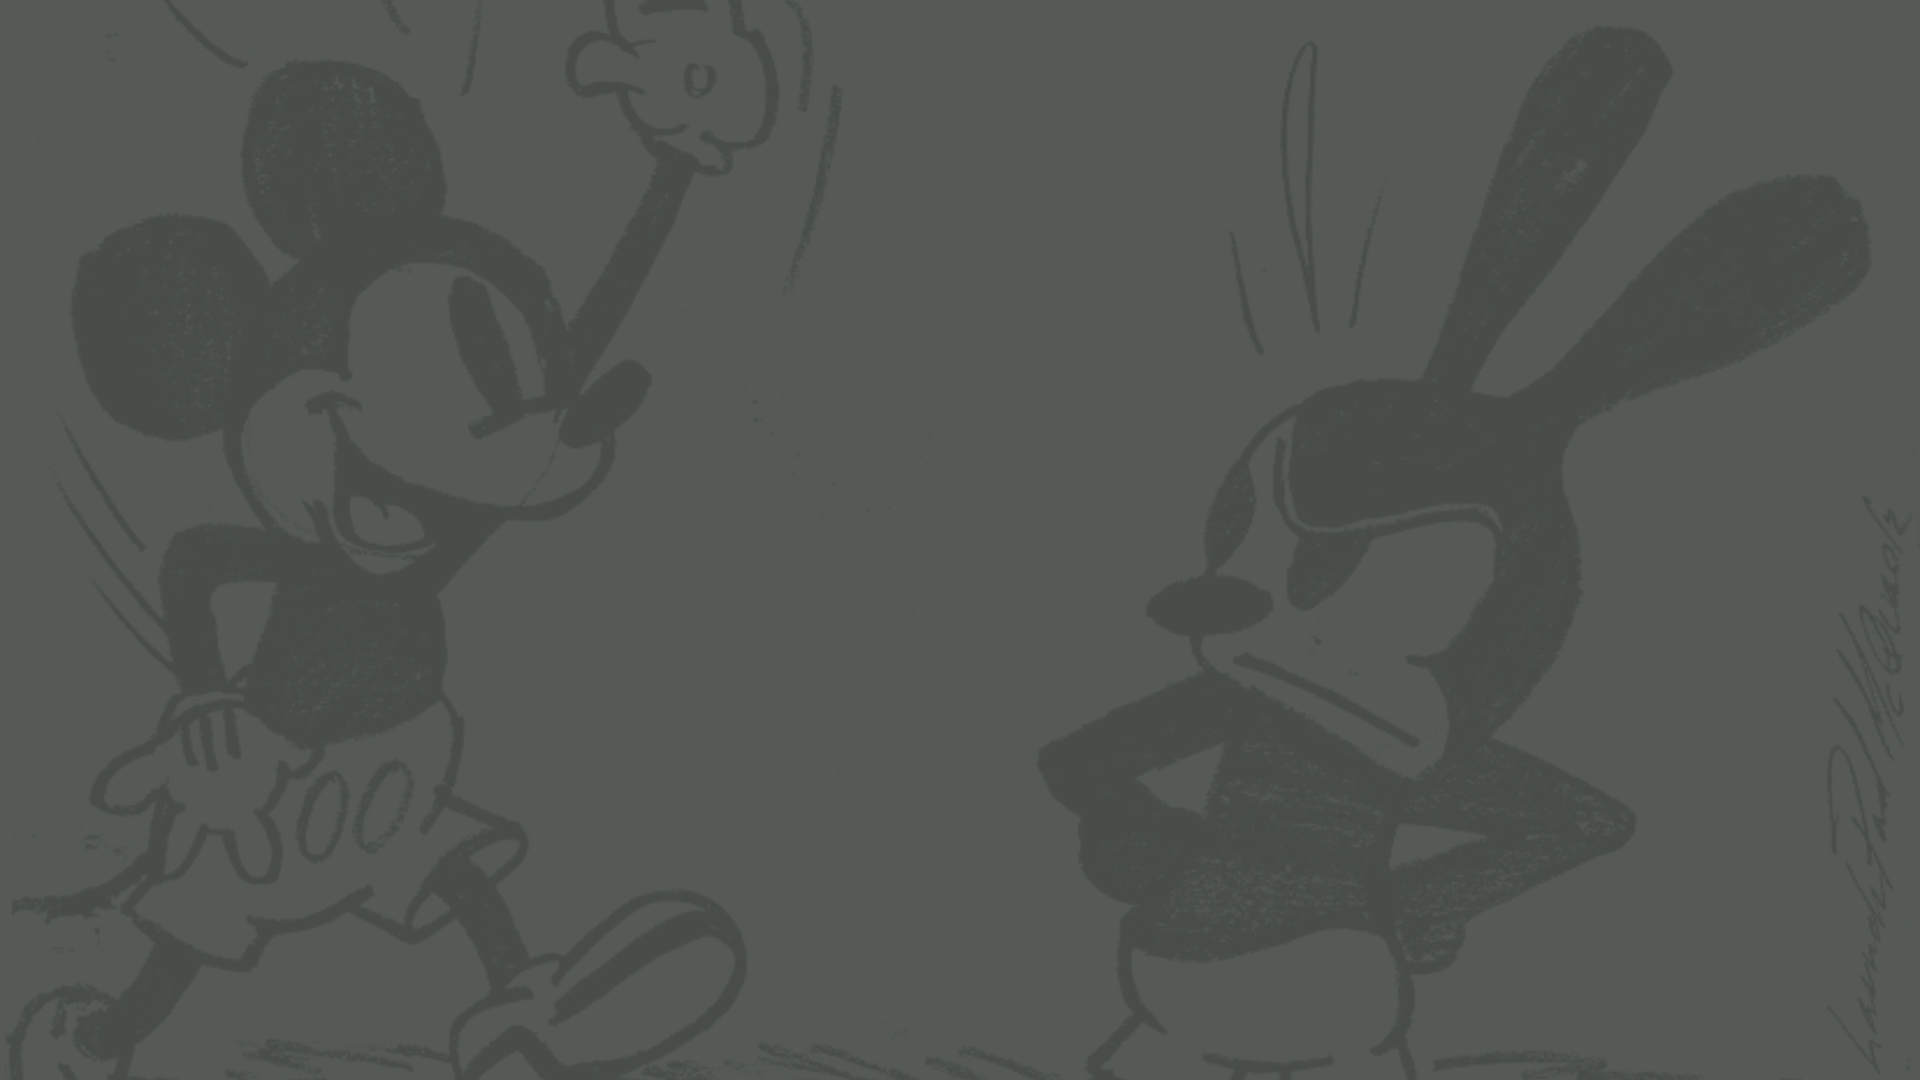Modules

In [52]:
#!pip install torch numpy pandas matplotlib scikit-learn statsmodels

import pandas as pd
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
plt.style.use('ggplot') #classic bmh Solarize_Light2 seaborn default fivethirtyeight dark_background ggplot
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score

from sklearn.neural_network import MLPRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F


# Dataset: Monthly CCI in Taiwan
*   Time Series Data
*   Source
  * [中華民國統計資訊網](https://www.stat.gov.tw/cp.aspx?n=2665)

  * [110年基期營造工程物價指數(CCI)計算平台](https://www.stat.gov.tw/CCI/CCI_Site/index.aspx)



In [2]:
# read csv

from google.colab import drive
drive.mount('/content/drive')
raw_data = pd.read_csv('/content/drive/My Drive/CCI.csv', encoding='utf-8', parse_dates=['TIME'])
raw_data = raw_data.loc[:, "TIME":"CCI"]
CCI = raw_data['CCI']
Time = raw_data['TIME']
print(raw_data.info())
raw_data.describe()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   TIME    394 non-null    datetime64[ns]
 1   CCI     394 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB
None


,CCI
count,394.000000
mean,71.704924
std,18.117365
min,43.680000
25%,53.475000
50%,75.815000
75%,84.920000
max,109.600000


## Data preprocessing


1. **對於線性回歸**
  * 要求時間序列數據平穩，否則可能導致模型偏差和不準確的預測。
  * 平穩化的數據通常會提高模型性能，特別是在預測長期趨勢時。
2. **對於ANN**
  * 人工神經網絡（ANN）是非線性模型，對非平穩數據有一定容忍度。
  * 但平穩化處理仍可改善學習效率和預測精度。特別是當數據具有強烈趨勢或季節性成分時，考慮預處理，如去趨勢或季節性調整。

### 平穩性檢驗：ADF test

- **ADF檢驗步驟**：
  - 模型設定：估計回歸模型以檢測序列中的單位根。

  - 統計檢驗：關注特定係數`\( \gamma \)`的值，以評估序列平穩性。
      
  - 計算ADF統計量：計算`\( \gamma \)`的估計值和相關統計信息。
      
  - 比較臨界值和p值：比較ADF統計量與臨界值，並檢查p值，以確定序列是否平穩。
- **原始 'CCI' 序列：**
  ```
    - ADF 統計量：-0.0177
    - p 值：0.9570
    - 臨界值：{'1%': -3.4472, '5%': -2.8690, '10%': -2.5707}
  ```
  - ADF 統計量高於所有臨界值，p 值高，這表示無法拒絕存在單位根的原假設。
  - 根據結果，原始 'CCI' 序列很可能是不平穩的。

### 平穩化：first order differencing

-  由於原始 'CCI' 序列顯示出不平穩的特徵，進行平穩化
   **差分處理**
  - **一階差分**：將每個時間點的數值減去前一個時間點的數值，以得到新的差分序列。
  -  **逆差分**：擬合與預測完成後再逆差分回來。

- **差分後的 'CCI' 序列：**
  ```
  - ADF 統計量：-9.2982
  - p 值：約 1.13e-15
  - 臨界值：{'1%': -3.4472, '5%': -2.8690, '10%': -2.5707}
  ```
  - ADF 統計量遠小於所有臨界值，p 值接近零，這表示可以在不同顯著性水平下拒絕存在單位根的原假設。
  - 差分後的 'CCI' 序列現在是平穩的。


In [3]:
# ADF test on the original data
print("\n original data \n", adfuller(CCI))

# first order differencing
diff_CCI = CCI.diff().dropna()

# ADF test on the differenced data
print("\n differenced data \n", adfuller(diff_CCI))

# inverse_difference function
def inverse_difference(diff_data, original_start):
    original_data = diff_data.copy()
    original_data.iloc[0] = original_start
    for i in range(1, len(diff_data)):
        original_data.iloc[i] = diff_data.iloc[i-1] + original_data.iloc[i-1]
    original_data.columns = ['y_pred']
    return original_data


 original data 
 (-0.017689290938736637, 0.9570445160443526, 2, 391, {'1%': -3.4471856790801514, '5%': -2.868960436182993, '10%': -2.5707229006220524}, 503.94732738533435)

 differenced data 
 (-9.298214003280203, 1.1309381586940943e-15, 1, 391, {'1%': -3.4471856790801514, '5%': -2.868960436182993, '10%': -2.5707229006220524}, 500.6518879752881)


### ACF、PACF test

- **特徵選擇**：ACF 和 PACF 結果可幫助確定應考慮多少滯後期作為輸入特徵，有助於明確定義模型的特徵。

- **時間窗口大小**：ACF 和 PACF 結果可指導決定輸入窗口大小，有助於為網絡提供足夠的信息。

- 根據業務需求和預測目標選擇特徵。

- 需平衡輸入特徵數量和模型複雜度，以避免過度擬合或過度簡化。

- 進行數據實驗和模型驗證，試驗不同輸入配置，使用交叉驗證確定最佳模型。

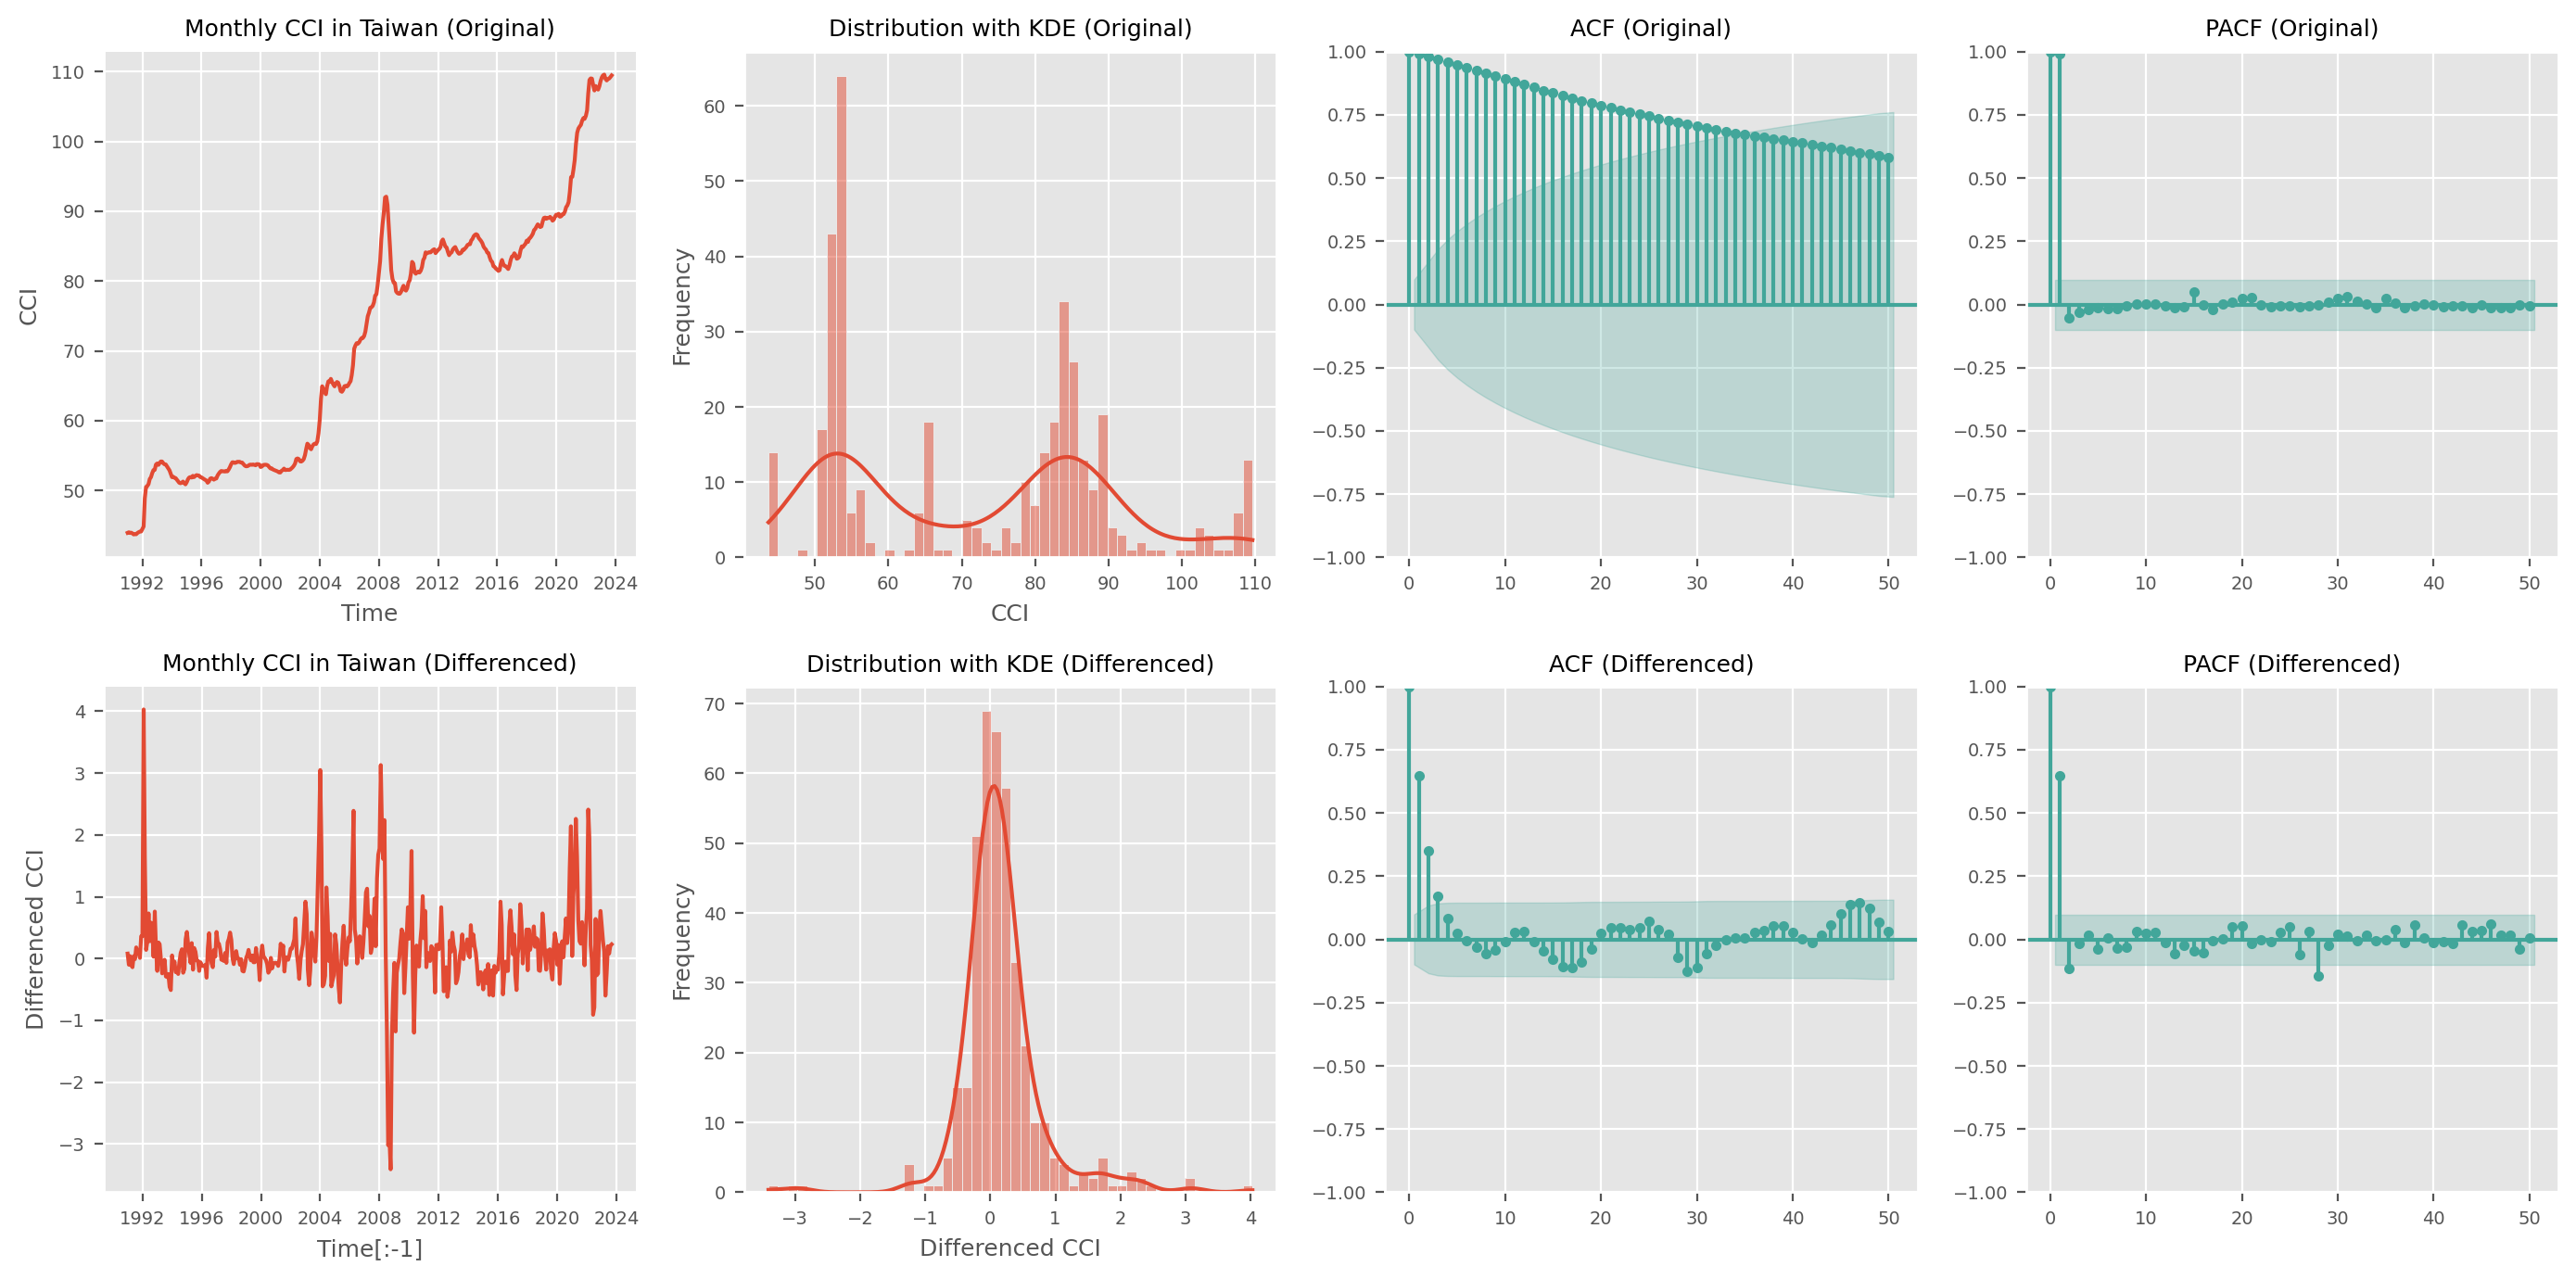

"\n不適合這邊用\n# pairplot\nsns.pairplot(X)\nplt.show()\n# heatmap\ncorrelation_matrix = X.corr()\nplt.figure(figsize=(10, 8))\nsns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.5f', linewidths=.5)\nplt.title('Correlation Heatmap')\nplt.show()\n"

In [4]:
fig, axs = plt.subplots(2, 4, figsize=(14, 7), dpi=200)

# Linear curve for original data
axs[0, 0].plot(Time, CCI)
axs[0, 0].set_title('Monthly CCI in Taiwan (Original)', fontsize=9)
axs[0, 0].spines[['top', 'right']].set_visible(False)
axs[0, 0].set_xlabel('Time', fontsize=9)
axs[0, 0].set_ylabel('CCI', fontsize=9)
axs[0, 0].tick_params(axis='both', labelsize=7)

# Histogram & KDE for original data
sns.histplot(CCI, bins=50, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Distribution with KDE (Original)', fontsize=9)
axs[0, 1].set_xlabel('CCI', fontsize=9)
axs[0, 1].set_ylabel('Frequency', fontsize=9)
axs[0, 1].tick_params(axis='both', labelsize=7)

# ACF and PACF plots for original data
plot_acf(CCI, ax=axs[0, 2], lags=50, markersize=3, title='ACF (Original)', color='#42A69A')
plot_pacf(CCI, ax=axs[0, 3], lags=50, markersize=3, title='PACF (Original)', color='#42A69A')

# Linear curve for differenced data
axs[1, 0].plot(Time[:-1], diff_CCI)  # 使用差分後的數據，並截斷 Time 的最後一個時間點
axs[1, 0].set_title('Monthly CCI in Taiwan (Differenced)', fontsize=9)
axs[1, 0].spines[['top', 'right']].set_visible(False)
axs[1, 0].set_xlabel('Time[:-1]', fontsize=9)
axs[1, 0].set_ylabel('Differenced CCI', fontsize=9)
axs[1, 0].tick_params(axis='both', labelsize=7)

# Histogram & KDE for differenced data
sns.histplot(diff_CCI, bins=50, kde=True, ax=axs[1, 1])
axs[1, 1].set_title('Distribution with KDE (Differenced)', fontsize=9)
axs[1, 1].set_xlabel('Differenced CCI', fontsize=9)
axs[1, 1].set_ylabel('Frequency', fontsize=9)
axs[1, 1].tick_params(axis='both', labelsize=7)

# ACF and PACF plots for differenced data
plot_acf(diff_CCI, ax=axs[1, 2], lags=50, markersize=3, title='ACF (Differenced)', color='#42A69A')
plot_pacf(diff_CCI, ax=axs[1, 3], lags=50, markersize=3, title='PACF (Differenced)', color='#42A69A')

for ax in axs.ravel():
    ax.title.set_fontsize(9)
    ax.tick_params(axis='both', labelsize=7)
for ax in [axs[0, 2], axs[0, 3], axs[1, 2], axs[1, 3]]:
    for line in ax.lines:
        line.set_color('#42A69A')  # 修改邊界線顏色
    for collection in ax.collections:
        collection.set_color('#42A69A')  # 修改填充顏色
    for markerline in ax.get_lines():
        markerline.set_markeredgecolor('#42A69A')  # 修改圓圈框框顏色

plt.tight_layout()
plt.show()


"""
不適合這邊用
# pairplot
sns.pairplot(X)
plt.show()
# heatmap
correlation_matrix = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.5f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()
"""

1. **CCI原始數據**顯示出明顯的上升趨勢和可能的周期性變化，這可能意味著數據具有非平穩性質。

2. **差分後的CCI數據**看起來更加隨機和平穩，這表明差分處理有助於移除趨勢和季節性影響，使數據更適合於某些時間序列預測模型，如ARIMA模型。

3. **ACF圖**顯示原始數據具有強烈的自相關性，而差分後的數據自相關性快速下降，這通常是平穩時間序列的特徵。

4. **PACF圖**對於確定適合的ARIMA模型參數非常有用，因為它可以幫助我們了解數據中的時間延遲(lags)如何影響當前值 => Lag order likely between 1~2.

儘管差分後的數據看起來更平穩，但這並不保證在所有情況下都能得到更好的預測模型。線性迴歸模型可能無法很好地適應這種平穩但沒有明顯線性趨勢的數據。另一方面，如果原始數據的趨勢很強，即使是簡單的線性模型也可能能夠捕捉到這種趨勢並做出不錯的預測。

因此，在進行時間序列分析時，應該考慮到數據的具體特徵和模型的適用性。在某些情況下，非平穩數據上的線性迴歸模型可能會有出人意料的好表現，特別是當趨勢明顯且數據量足夠大時。而在其他情況下，如數據經過差分後顯示出隨機行走的特徵，則可能需要使用不同類型的模型，如ARIMA或季節性ARIMA（SARIMA）模型，來捕捉數據中的結構。


---


線性迴歸（Linear Regression）模型在處理數據時，平穩化的影響因數據特性和模型目的而異：

1. **非平穩性數據：** 線性迴歸通常假設數據具有線性關係和恆定變異性。若數據有趨勢或季節性等非平穩特性，可考慮平穩化處理以使模型適應。

2. **模型選擇：** 非平穩數據可使用差分等處理方法，或考慮使用時間序列模型。選擇取決於數據特性。

3. **輸入特徵：** 選擇輸入特徵需考慮平穩化的影響，特別是差分處理可能影響時間滯後特徵的選取。

4. **性能評估：** 使用適當評估指標評估模型性能，如均方誤差和R平方。

總結，平穩化數據可能根據情況改善線性迴歸模型性能，但需視數據和模型選擇而定。對於非平穩數據，平穩化或其他模型可能更適合。

---


人工神經網絡（ANN）模型之於平穩化數據：

1. **非平穩性數據：** 若數據有趨勢或季節性，建議平穩化處理。網絡架構需根據數據特性設計。

2. **網絡架構：** 平穩數據可用較簡單網絡，非平穩數據可能需要複雜網絡以捕捉結構。

3. **輸入特徵：** 時間序列數據需考慮輸入特徵，平穩化可簡化此過程。

4. **訓練和調參：** 平穩化可簡化訓練，但仍需調參以適應平穩化數據。

總結，平穩化可能提高ANN性能，但需視數據特性和目標調整應用方法。建議初步分析後再決定是否平穩化。

### 特徵提取：Window Sliding

滑動窗口技術（Window Sliding）：

- 滑動窗口技術用於時間序列數據特徵提取，創建一系列時間窗口，每個包含連續時間步。
- 這些窗口可用於訓練機器學習模型，窗口內的數據是模型輸入，下一時間步是預測目標。根據過去數據預測未來。

滯後（Lag）：

- 指某時間點的觀察值相對於先前時間點的時間差，通常表示為Lag k。
- 滯後值可用於建立預測模型中的特徵，納入過去數據進行預測。

輸入特徵數量：

- 基於 ACF 和 PACF 的分析，選擇窗口大小捕捉數據自相關性，避免過度擴展以防止過擬合。

輸出目標數量：

- 取決於預測目標，單步預測時 output_number 為1，多步預測時可增加。

EX: 使用前一期（t-1）和前前一期（t-2）的資料來預測下一期（t）和下下一期（t+1）

- Lag 0 是當前期（t）
- Lag 1 是前一期的數據
- Lag 2 是前前一期的數據
- 例如使用 Lag 1 和 Lag 2 的數據來預測 t 期或 t+1 期的數據。在這種情況下，Lag 1 和 Lag 2 的數據成為了您模型的輸入特徵。

In [5]:
# hyperparameter
input_number = 2  # 假設基於您的ACF和PACF分析: Lag order likely between 1 to 2.
output_number = 1  # 假設進行單步預測

# Feature Extraction : Window Sliding
def create_windowed_data(raw_Time_Series_data, Time, input_number, output_number):
    window_size = input_number + output_number

    X = pd.DataFrame(index=raw_Time_Series_data.index)
    y = pd.DataFrame(index=raw_Time_Series_data.index)
    X_time = pd.DataFrame(index=Time.index)
    y_time = pd.DataFrame(index=Time.index)

    for i in range(window_size):
        if i < output_number:
            y[f'Label_Next{i+1}'] = raw_Time_Series_data.shift(-i)
            y_time[f'Time_Next{i+1}'] = Time.shift(-i)
        else:
            lag = i - output_number +1
            X[f'Input_Lag{lag}'] = raw_Time_Series_data.shift(lag)
            X_time[f'Time_Lag{lag}'] = Time.shift(lag)

    X = X.iloc[window_size-1:-output_number]
    y = y.iloc[window_size-1:-output_number]
    X_time = X_time.iloc[window_size-1:-output_number]
    y_time = y_time.iloc[window_size-1:-output_number]

    return X, y, X_time, y_time

 # Models using "scikit-learn"
 popular Python machine learning library

## Spliting Datasets

Training set : X_train  (ground truth : y_train) : 70%

Validation set : X_val  (ground truth : y_val) : 30%

In [29]:
def split_data_2(X, y, X_time, y_time):

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
    X_train_time, X_temp_time, y_train_time, y_temp_time = train_test_split(X_time, y_time, test_size=0.3, shuffle=False)

    return X_train, X_train_time, y_train, y_train_time, X_test, X_test_time, y_test, y_test_time


In [30]:
# Original Data
X, y, X_time, y_time = create_windowed_data(CCI, Time, input_number, output_number)
X_train, X_train_time, y_train, y_train_time, X_temp, X_temp_time, y_temp, y_temp_time = split_data_2(X, y, X_time, y_time)

# Differenced Data
diff_X, diff_y, diff_X_time, diff_y_time = create_windowed_data(diff_CCI, Time[:-1], input_number, output_number)
diff_X_train, diff_X_train_time, diff_y_train, diff_y_train_time, diff_X_test, diff_X_test_time, diff_y_test, diff_y_test_time = split_data_2(diff_X, diff_y, diff_X_time, diff_y_time)

## Model1 - Linear Regression Model  ( Original Data )  

In [31]:
# Linear Regression Model
model1_LR = LinearRegression()

# Training
model1_LR.fit(X_train, y_train)

# 顯示訓練後的模型參數
beta_0 = model1_LR.intercept_[0]
beta_1, beta_2 = model1_LR.coef_[0]

# Testing (Predicting)
y_pred_LR = model1_LR.predict(X_test)

# Performance Evaluation
rmse_LR = mean_squared_error(y_test, y_pred_LR, squared=False)
mae_LR = mean_absolute_error(y_test, y_pred_LR)
mape_LR = mean_absolute_percentage_error(y_test, y_pred_LR)
r2_LR = r2_score(y_test, y_pred_LR)

y_pred_df = pd.DataFrame({'y_pred': y_pred_LR.ravel()})
combined_df = pd.concat([y_test_time.reset_index(drop=True),
                         X_test_time.reset_index(drop=True),
                         y_pred_df.reset_index(drop=True),
                         y_test.reset_index(drop=True),
                         X_test.reset_index(drop=True)], axis=1)
combined_df.to_csv('/content/drive/My Drive/LR_testing_data_result(original).csv', index=False)

## Model2 - Linear Regression Model ( Differrenced Data )

In [32]:
# Linear Regression Model (trained by differenced data)
model1_LR_diff = LinearRegression()

# Training
model1_LR_diff.fit(diff_X_train, diff_y_train)

# 顯示訓練後的模型參數
beta_0 = model1_LR_diff.intercept_[0]
beta_1, beta_2 = model1_LR_diff.coef_[0]

# Testing (Predicting)
y_pred_diff = model1_LR_diff.predict(diff_X_test)

# 將預測值逆差分回來
original_start = y_test.iloc[0]
y_pred = inverse_difference(pd.Series(y_pred_diff.flatten()), original_start)
y_pred_LR_diff = y_pred.rename('y_pred')

# Performance Evaluation
rmse_LR_diff = mean_squared_error(y_test, y_pred_LR_diff, squared=False)
mae_LR_diff = mean_absolute_error(y_test, y_pred_LR_diff)
mape_LR_diff = mean_absolute_percentage_error(y_test, y_pred_LR_diff)
r2_LR_diff = r2_score(y_test, y_pred_LR_diff)

y_pred_df = pd.DataFrame({'y_pred': y_pred_LR_diff.ravel()})
combined_df = pd.concat([y_test_time.reset_index(drop=True),
                         X_test_time.reset_index(drop=True),
                         y_pred_LR_diff.reset_index(drop=True),
                         y_test.reset_index(drop=True),
                         X_test.reset_index(drop=True)], axis=1)
combined_df.to_csv('/content/drive/My Drive/LR_testing_data_result(diff).csv', index=False)

## Model3 - ANN / NN ( MLP ) Model  ( Original Data )


```
在 scikit-learn 的 MLPRegressor 中，loss_curve_ 屬性僅在使用隨機梯度下降求解器（solver='sgd' 或 solver='adam'）時才可用，因為這些求解器是迭代的。
```



In [33]:
# ANN Model
model2_ANN = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='lbfgs', max_iter=500)
#model2_ANN = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500)
#model2_ANN = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='sgd', max_iter=500)
#model2_ANN = MLPRegressor(hidden_layer_sizes=(100,), activation='logistic', solver='sgd', max_iter=500)
#model2_ANN = MLPRegressor(hidden_layer_sizes=(100,), activation='tanh', solver='lbfgs', max_iter=500)

# Training
model2_ANN.fit(X_train, y_train)

# Testing (Predicting)
y_pred_ANN = model2_ANN.predict(X_test)

# Performance Evaluation
rmse_ANN = mean_squared_error(y_test, y_pred_ANN , squared=False)
mae_ANN = mean_absolute_error(y_test, y_pred_ANN )
mape_ANN = mean_absolute_percentage_error(y_test, y_pred_ANN )
r2_ANN = r2_score(y_test, y_pred_ANN )

y_pred_df = pd.DataFrame({'y_pred': y_pred_ANN .ravel()})
combined_df = pd.concat([y_test_time.reset_index(drop=True),
                         X_test_time.reset_index(drop=True),
                         y_pred_df.reset_index(drop=True),
                         y_test.reset_index(drop=True),
                         X_test.reset_index(drop=True)], axis=1)
combined_df.to_csv('/content/drive/My Drive/ANN_testing_data_result(original).csv', index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Model4 - ANN / NN ( MLP ) Model ( Differenced Data )

In [34]:
# ANN Model (trained by differenced data)
model2_ANN_diff = MLPRegressor(hidden_layer_sizes=(100,), activation='logistic', solver='lbfgs', max_iter=500)
#model2_ANN_diff = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500)
#model2_ANN_diff = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='sgd', max_iter=500)
#model2_ANN_diff = MLPRegressor(hidden_layer_sizes=(100,), activation='tanh', solver='sgd', max_iter=500)
#model2_ANN_diff = MLPRegressor(hidden_layer_sizes=(100,), activation='logistic', solver='sgd', max_iter=500)


# Training
model2_ANN_diff.fit(diff_X_train, diff_y_train)

# Testing (Predicting)
y_pred_diff = model2_ANN_diff.predict(diff_X_test)

# 將預測值逆差分回來
original_start = y_test.iloc[0]
y_pred = inverse_difference(pd.Series(y_pred_diff.flatten()), original_start)
y_pred_ANN_diff = y_pred.rename('y_pred')

# Performance Evaluation
rmse_ANN_diff = mean_squared_error(y_test, y_pred_ANN_diff, squared=False)
mae_ANN_diff = mean_absolute_error(y_test, y_pred_ANN_diff)
mape_ANN_diff = mean_absolute_percentage_error(y_test, y_pred_ANN_diff)
r2_ANN_diff = r2_score(y_test, y_pred_ANN_diff)

y_pred_df = pd.DataFrame({'y_pred': y_pred_ANN_diff.ravel()})
combined_df = pd.concat([y_test_time.reset_index(drop=True),
                         X_test_time.reset_index(drop=True),
                         y_pred_df.reset_index(drop=True),
                         y_test.reset_index(drop=True),
                         X_test.reset_index(drop=True)], axis=1)
combined_df.to_csv('/content/drive/My Drive/ANN_testing_data_result(diff).csv', index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## Model Results + Plot Comparison

                             Model    RMSE     MAE    MAPE R2 Score
0     Linear Regression (Original)  0.5858  0.4269  0.0043   0.9953
1  Linear Regression (Differenced)  3.5786  2.7427  0.0262   0.8252
2                   ANN (Original)  0.5858  0.4269  0.0043   0.9953
3                ANN (Differenced)  3.4395  2.6081  0.0249   0.8385


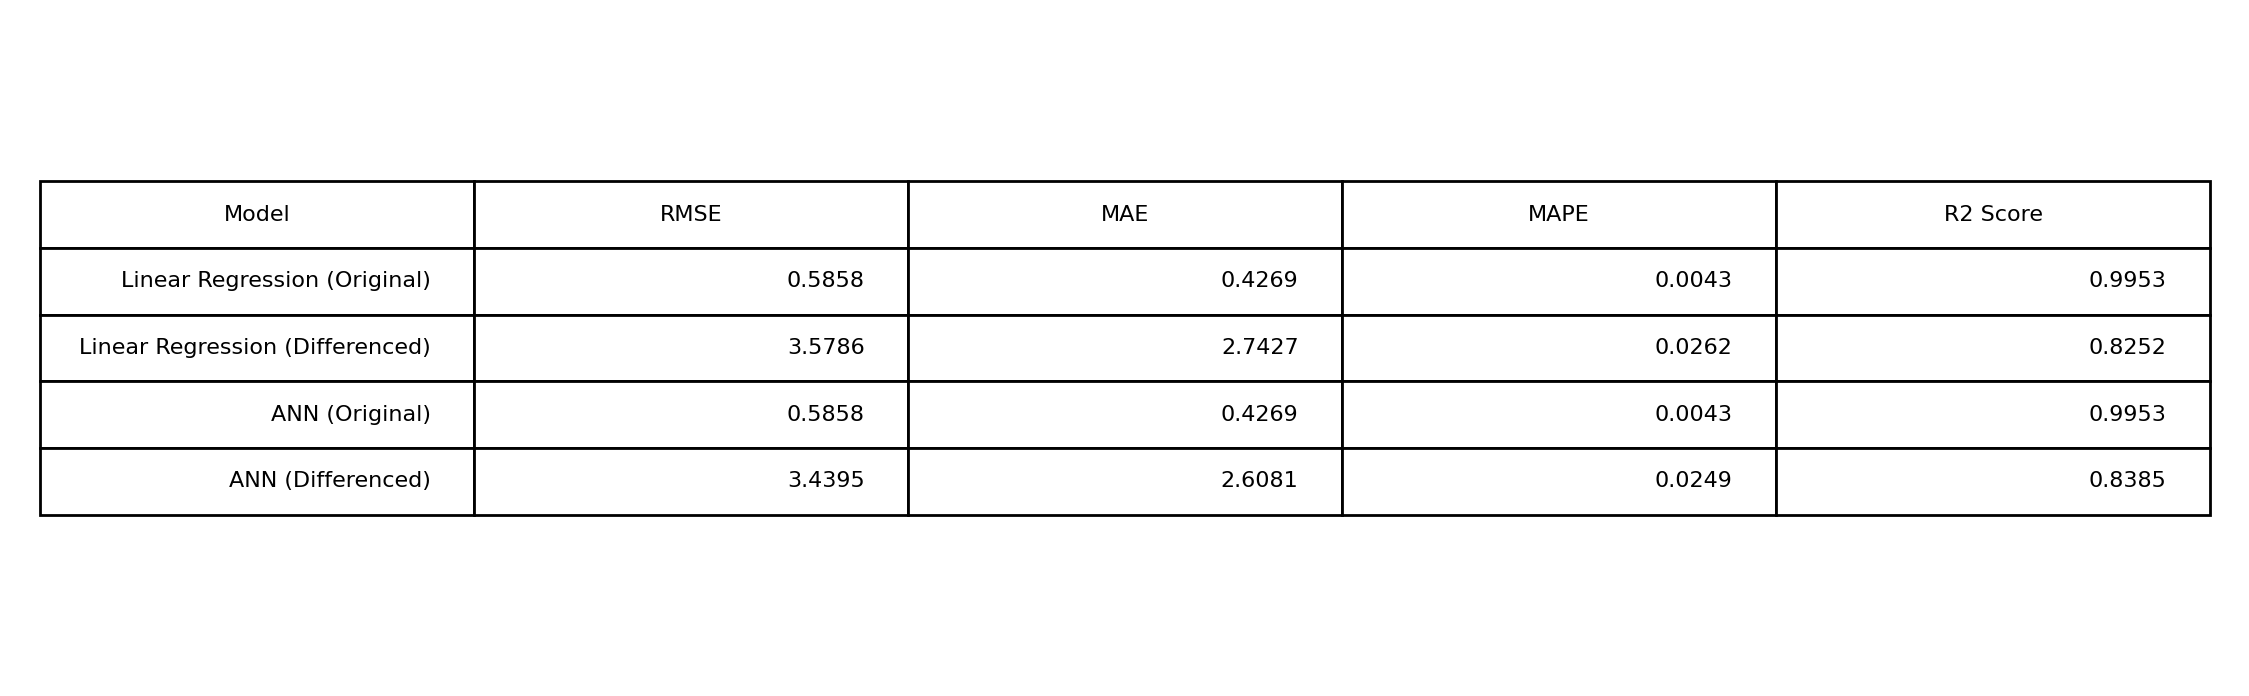

In [26]:
data = {
    "Model": [
        "Linear Regression (Original)",
        "Linear Regression (Differenced)",
        "ANN (Original)",
        "ANN (Differenced)"
    ],
    "RMSE": [f"{rmse_LR:.4f}", f"{rmse_LR_diff:.4f}", f"{rmse_ANN:.4f}", f"{rmse_ANN_diff:.4f}"],
    "MAE": [f"{mae_LR:.4f}", f"{mae_LR_diff:.4f}", f"{mae_ANN:.4f}", f"{mae_ANN_diff:.4f}"],
    "MAPE": [f"{mape_LR:.4f}", f"{mape_LR_diff:.4f}", f"{mape_ANN:.4f}", f"{mape_ANN_diff:.4f}"],
    "R2 Score": [f"{r2_LR:.4f}", f"{r2_LR_diff:.4f}", f"{r2_ANN:.4f}", f"{r2_ANN_diff:.4f}"]
}

results_df = pd.DataFrame(data)

print(results_df)


fig, ax = plt.subplots(figsize=(7, 2), dpi=400)
ax.axis('tight')
ax.axis('off')
ax.table(cellText=results_df.values, colLabels=results_df.columns, loc='center')
plt.show()

In [27]:
print("LINEAR REGRESSION TRAINED WITH ORIGINAL DATA")
print(beta_0, beta_1, beta_2)
print("RMSE: {:.9f}".format(rmse_LR))
print("MAE: {:.9f}".format(mae_LR))
print("MAPE: {:.9f}%".format(mape_LR))
print("R2score: {:.9%}".format(r2_LR))

print("LINEAR REGRESSION TRAINED WITH DIFFERENCED DATA")
print(beta_0, beta_1, beta_2)
print("RMSE: {:.9f}".format(rmse_LR_diff))
print("MAE: {:.9f}".format(mae_LR_diff))
print("MAPE: {:.9%}".format(mape_LR_diff))
print("R2score: {:.9%}".format(r2_LR_diff))

print("ANN TRAINED WITH ORIGINAL DATA")
print(beta_0, beta_1, beta_2)
print("RMSE: {:.9f}".format(rmse_ANN))
print("MAE: {:.9f}".format(mae_ANN))
print("MAPE: {:.9f}%".format(mape_ANN))
print("R2score: {:.9%}".format(r2_ANN))

print("ANN TRAINED WITH DIFFERENCED DATA")
print(beta_0, beta_1, beta_2)
print("RMSE: {:.9f}".format(rmse_ANN_diff))
print("MAE: {:.9f}".format(mae_ANN_diff))
print("MAPE: {:.9f}%".format(mape_ANN_diff))
print("R2score: {:.9%}".format(r2_ANN_diff))

LINEAR REGRESSION TRAINED WITH ORIGINAL DATA
0.05684651333440746 0.7451742578044457 -0.11973602250269105
RMSE: 0.585751068
MAE: 0.426891234
MAPE: 0.004326302%
R2score: 99.531683207%
LINEAR REGRESSION TRAINED WITH DIFFERENCED DATA
0.05684651333440746 0.7451742578044457 -0.11973602250269105
RMSE: 3.578574353
MAE: 2.742651333
MAPE: 2.620301078%
R2score: 82.520313376%
ANN TRAINED WITH ORIGINAL DATA
0.05684651333440746 0.7451742578044457 -0.11973602250269105
RMSE: 0.585750437
MAE: 0.426890971
MAPE: 0.004326299%
R2score: 99.531684216%
ANN TRAINED WITH DIFFERENCED DATA
0.05684651333440746 0.7451742578044457 -0.11973602250269105
RMSE: 3.439547822
MAE: 2.608094635
MAPE: 0.024898202%
R2score: 83.852092383%


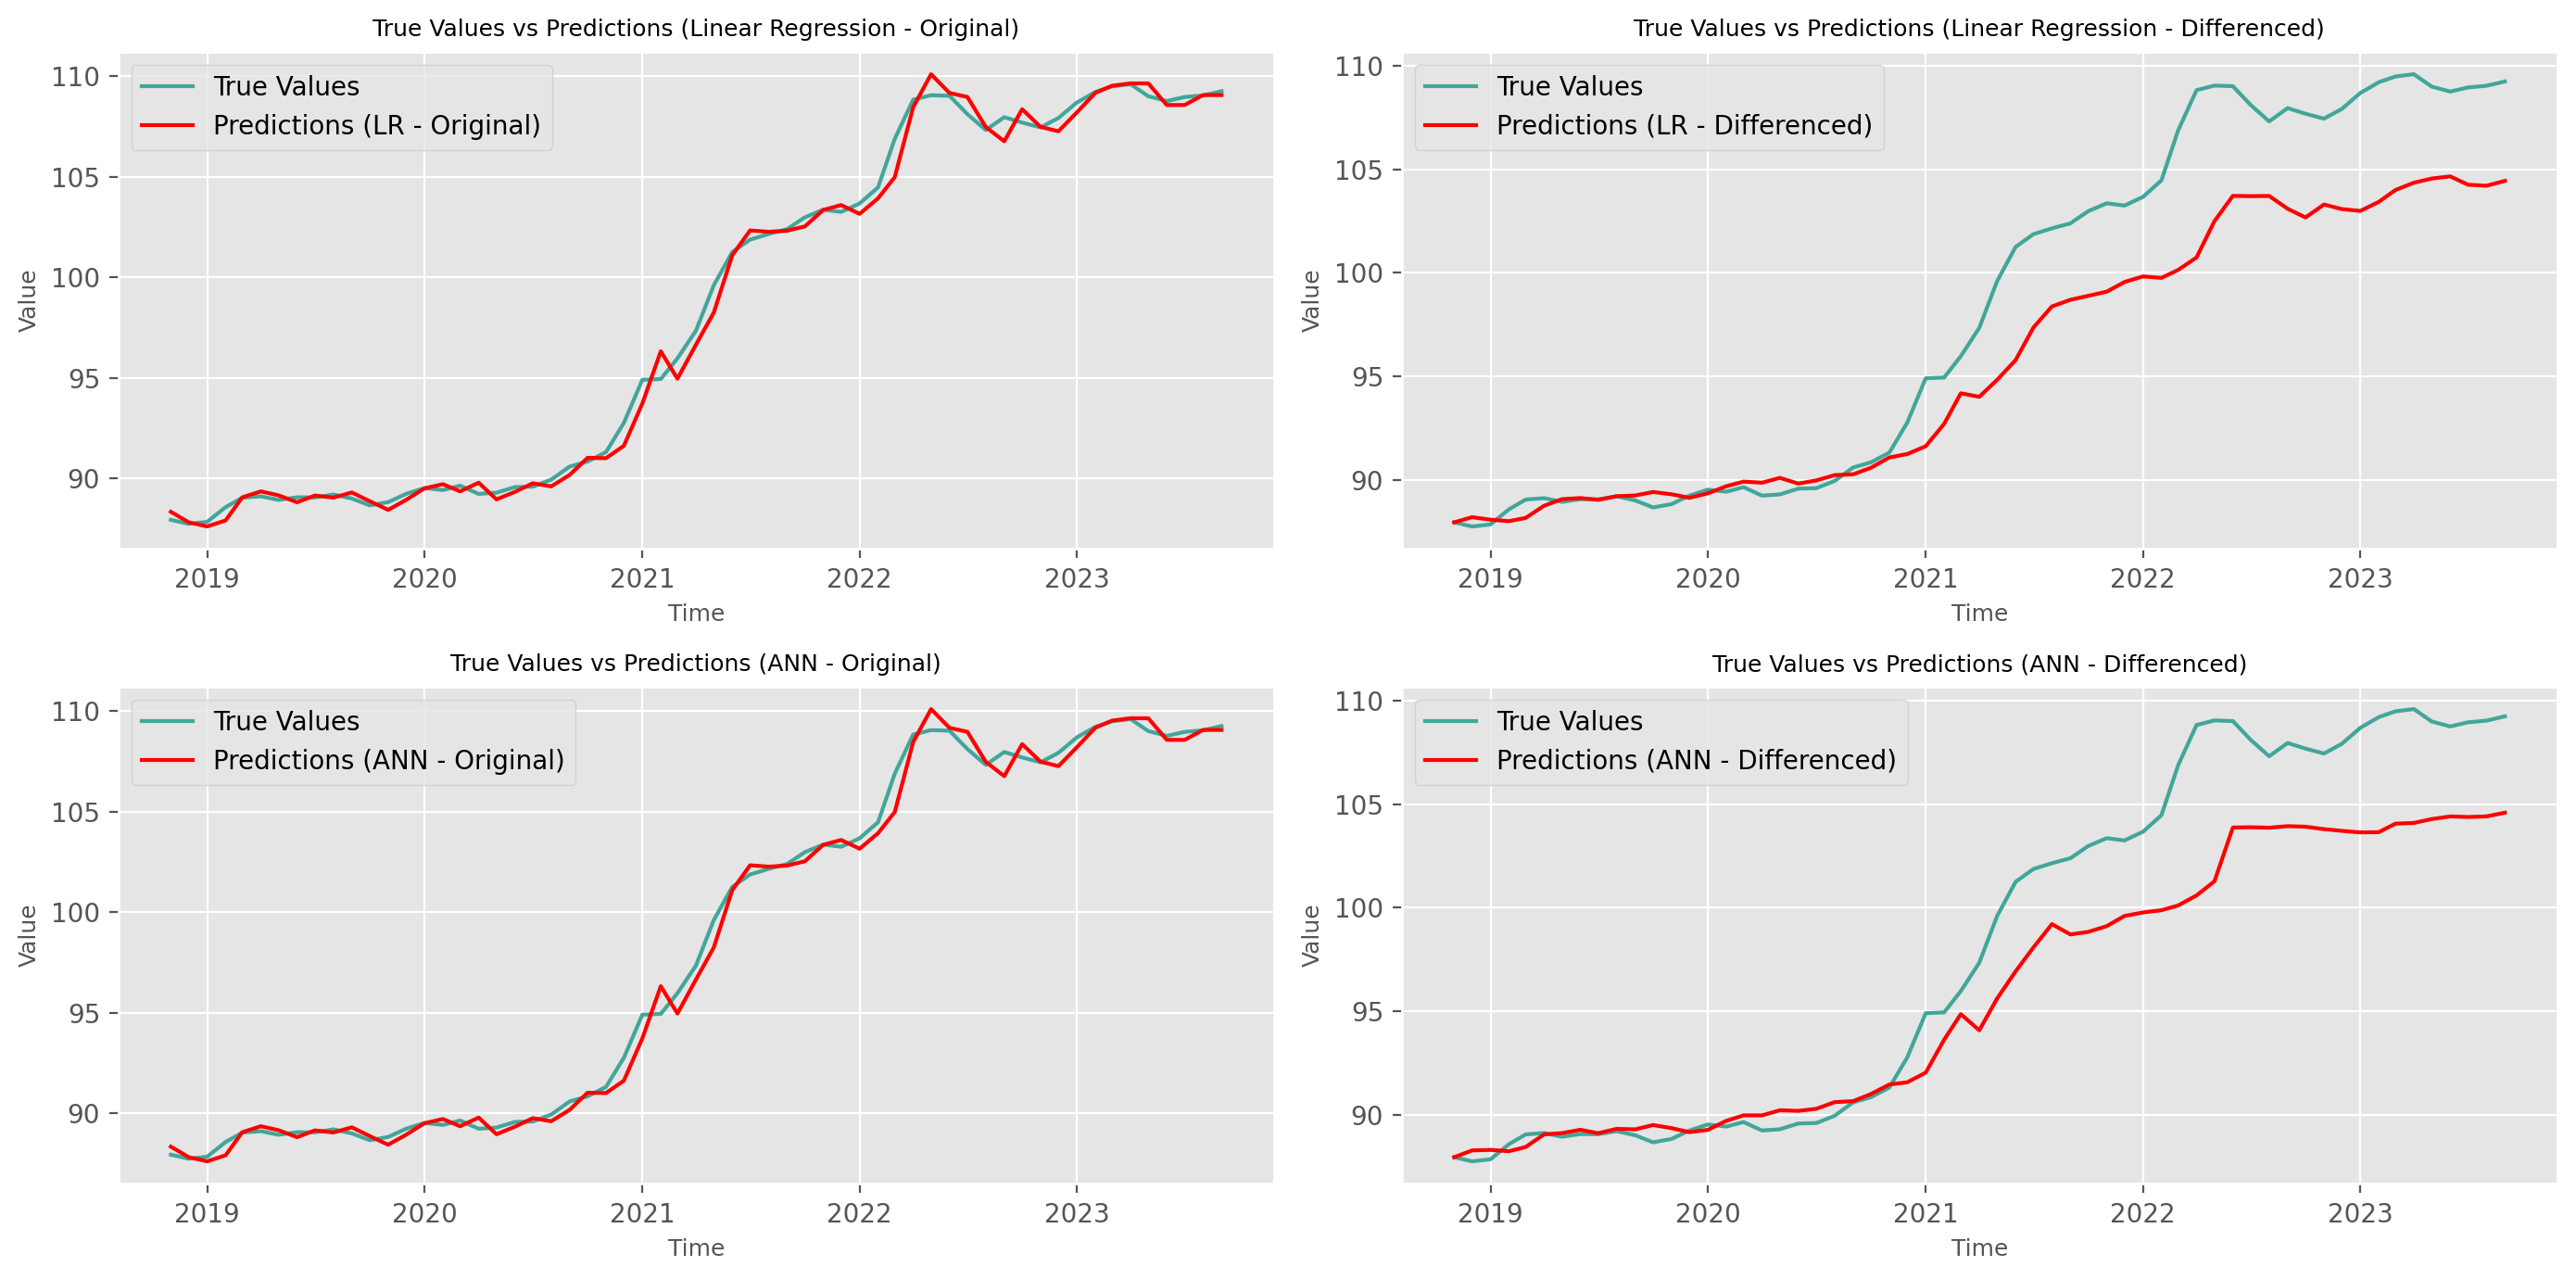

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(14, 7), dpi=200)

# 第一張圖（左上）
axs[0, 0].plot(y_test_time, y_test, label='True Values', color='#42A69A')
axs[0, 0].plot(y_test_time, y_pred_LR, label='Predictions (LR - Original)', color='red')
axs[0, 0].set_title('True Values vs Predictions (Linear Regression - Original)', fontsize=9)
axs[0, 0].set_xlabel('Time', fontsize=9)
axs[0, 0].set_ylabel('Value', fontsize=9)
axs[0, 0].legend()

# 第二張圖（右上）
axs[0, 1].plot(y_test_time, y_test, label='True Values', color='#42A69A')
axs[0, 1].plot(y_test_time, y_pred_LR_diff, label='Predictions (LR - Differenced)', color='red')
axs[0, 1].set_title('True Values vs Predictions (Linear Regression - Differenced)', fontsize=9)
axs[0, 1].set_xlabel('Time', fontsize=9)
axs[0, 1].set_ylabel('Value', fontsize=9)
axs[0, 1].legend()

# 第三張圖（左下）
axs[1, 0].plot(y_test_time, y_test, label='True Values', color='#42A69A')
axs[1, 0].plot(y_test_time, y_pred_ANN, label='Predictions (ANN - Original)', color='red')
axs[1, 0].set_title('True Values vs Predictions (ANN - Original)', fontsize=9)
axs[1, 0].set_xlabel('Time', fontsize=9)
axs[1, 0].set_ylabel('Value', fontsize=9)
axs[1, 0].legend()

# 第四張圖（右下）
axs[1, 1].plot(y_test_time, y_test, label='True Values', color='#42A69A')
axs[1, 1].plot(y_test_time, y_pred_ANN_diff, label='Predictions (ANN - Differenced)', color='red')
axs[1, 1].set_title('True Values vs Predictions (ANN - Differenced)', fontsize=9)
axs[1, 1].set_xlabel('Time', fontsize=9)
axs[1, 1].set_ylabel('Value', fontsize=9)
axs[1, 1].legend()


plt.tight_layout()
plt.show()

1. **對於線性回歸**：
   - 線性迴歸確實假設獨立變量和因變量之間存在線性關係。對於時間序列數據，如果存在趨勢或季節性，則數據是非平穩的，這可能導致模型的統計假設遭到破壞，進而導致模型估計偏差和不準確的預測。
   - 平穩化通常是透過差分等方法來去除趨勢和季節性，從而使數據適用於線性迴歸模型。但這並不是絕對的，有時候模型可能直接對原始數據或經過變換（如對數變換）後的數據表現良好。

2. **對於ANN**：
   - 人工神經網絡作為非線性模型，對數據的非平穩性有更高的容忍度。它能夠透過學習隱藏層中的非線性關係來適應數據的複雜結構。
   - 即使如此，對數據進行平穩化處理，如去除明顯的趨勢和季節性，有助於降低問題的複雜性，使得網絡更容易學習數據中的基本結構，從而提高學習效率和預測精度。

在您的案例中，原始數據上訓練的線性迴歸模型表現得出乎意料地好，可能是因為數據的趨勢和季節性對預測來說非常重要，而這些組件在差分後的數據中被移除了。這說明在特定情況下，數據的非平穩性可能對於某些預測任務是有益的，而不是一個障礙。

最後，每個模型的適用性都需要根據數據的具體情況來評估。在選擇合適的模型和預處理技術時，需要考慮數據的特性、模型的假設以及預測目標。

# Models created by ourselves by pytorch

pytorch = open-source deep learning framework

依照上面的情況，平穩化過的資料沒有表現得比較好，因此在我們自己建的模型，就只用原始資料去訓練。（有空再說）

**見另外兩個檔案**

[**Linear Regression ( By 范翊瑜 )**](https://colab.research.google.com/drive/13mmcqa423JVntuyXhzUVDRrHvKwTKzUi?usp=sharing#scrollTo=SX2m12OgUqNT)

[**ANN ( By 吳巽言 )**](https://colab.research.google.com/drive/1JG-9S8Mq4Ty1PJW4HuVSFiYrQ5npT_eP?usp=sharing&hl=en#scrollTo=83mdvFBWCDrP)

這邊也都表現得很好，ANN跟預想中一樣表現得略好一點點。

<br>
<br>
<br>
<br>

---


**END of the Final Presentation :) THANK YOU!!!**

TOPIC:Forecasting Future Taiwan Construction Cost Index, CCI (Regression Problem)

[**Presentation PPT in Class**](https://docs.google.com/presentation/d/1PgMIFw71Sz8tsB4q_KQkdoG4eABM-teLpmqktEwvjUM/edit?usp=sharing)

CLASS:
Applications of Artificial Intelligence in Project Management

GROUP:
109612054 吳巽言
112612801 范翊瑜

---

<br>
<br>
<br>
<br>

## Spliting Datasets

Training set : X_train  (ground truth : y_train) : 70%

Validation set : X_val  (ground truth : y_val) : 15%

Testing set : X_test    (ground truth : y_test) : 15%

In [ ]:
# Original Data
X, y, X_time, y_time = create_windowed_data(CCI, Time, input_number, output_number)
X_train, X_train_time, y_train, y_train_time, X_val, X_val_time, y_val, y_val_time, X_test, X_test_time, y_test, y_test_time = split_data_3(X, y, X_time, y_time)
combined_df = pd.concat([y_train_time.reset_index(drop=True), X_train_time.reset_index(drop=True), y_train.reset_index(drop=True), X_test.reset_index(drop=True)], axis=1)
combined_df.to_csv('/content/drive/My Drive/training_data(original).csv', index=False)
combined_df = pd.concat([y_val_time.reset_index(drop=True), X_val_time.reset_index(drop=True), y_val.reset_index(drop=True), X_val.reset_index(drop=True)], axis=1)
combined_df.to_csv('/content/drive/My Drive/valid_data(original).csv', index=False)
combined_df = pd.concat([y_test_time.reset_index(drop=True), X_test_time.reset_index(drop=True), y_test.reset_index(drop=True), X_test.reset_index(drop=True)], axis=1)
combined_df.to_csv('/content/drive/My Drive/testing_data(original).csv', index=False)

# Differenced Data
diff_X, diff_y, diff_X_time, diff_y_time = create_windowed_data(diff_CCI, Time[:-1], input_number, output_number)
diff_X_train, diff_X_train_time, diff_y_train, diff_y_train_time, diff_X_val, diff_X_val_time, diff_y_val, diff_y_val_time, diff_X_test, diff_X_test_time, diff_y_test, diff_y_test_time = split_data_3(diff_X, diff_y, diff_X_time, diff_y_time)
combined_df = pd.concat([diff_y_train_time.reset_index(drop=True), diff_X_train_time.reset_index(drop=True), diff_y_train.reset_index(drop=True), diff_X_train.reset_index(drop=True)], axis=1)
combined_df.to_csv('/content/drive/My Drive/training_data(diff).csv', index=False)
combined_df = pd.concat([diff_y_val_time.reset_index(drop=True), diff_X_val_time.reset_index(drop=True), diff_y_val.reset_index(drop=True), diff_X_val.reset_index(drop=True)], axis=1)
combined_df.to_csv('/content/drive/My Drive/valid_data(diff).csv', index=False)
combined_df = pd.concat([diff_y_test_time.reset_index(drop=True), diff_X_test_time.reset_index(drop=True), diff_y_test.reset_index(drop=True), diff_X_test.reset_index(drop=True)], axis=1)
combined_df.to_csv('/content/drive/My Drive/testing_data(diff).csv', index=False)

In [6]:
def split_data_3(X, y, X_time, y_time):

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
    X_train_time, X_temp_time, y_train_time, y_temp_time = train_test_split(X_time, y_time, test_size=0.3, shuffle=False)
    X_val_time, X_test_time, y_val_time, y_test_time = train_test_split(X_temp_time, y_temp_time, test_size=0.5, shuffle=False)

    return X_train, X_train_time, y_train, y_train_time, X_val, X_val_time, y_val, y_val_time, X_test, X_test_time, y_test, y_test_time


## Model5 - Linear Regression Model  ( Original Data )  

 - 線性迴歸模型（Linear Regression）和激活函數（Activation Function）通常不直接相關。線性迴歸是一種用於解決回歸問題的機器學習方法，它建立線性模型，不包括激活函數，因為它是一個線性模型。激活函數主要用於神經網絡中，引入非線性性質，以處理複雜模式和非線性關係。

 - 線性迴歸模型與優化器（Optimizer）之間有關聯，因為優化器用於調整線性迴歸模型的參數，以最小化損失函數，進而改進模型的適應性。

 - Scikit-learn 中的線性迴歸模型（Linear Regression）通常是一次 fit（擬合）而不需要額外的訓練多個 epochs 的模型。這是因為 scikit-learn 中的線性迴歸是一種傳統的線性模型，不涉及深度學習的概念，並且不需要多次迭代來訓練。它通常使用最小二乘法（Ordinary Least Squares，OLS）或類似的方法來找到最佳的權重和截距，以最小化預測值和實際值之間的均方誤差。

In [48]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressionModel, self).__init__()
        self.linear1 = nn.Linear(input_size, output_size)
        #self.activate = nn.ReLU()
        #self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.linear1(x)
        #x = self.activate(x)
        #x = self.linear2(x)
        return x

In [41]:
def prepare_data(X_train, y_train, X_val, y_val, X_test, y_test, batch_size):
    # 對數值型數據進行標準化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # 轉換為 PyTorch 張量
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

    # 創建 DataLoader
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [42]:
def calculate_metrics(outputs, targets):
    mse = F.mse_loss(outputs, targets, reduction='mean').item()
    mae = F.l1_loss(outputs, targets, reduction='mean').item()
    mape = torch.mean(torch.abs((targets - outputs) / targets)).item()
    rmse = np.sqrt(mse)
    r2 = r2_score(targets.cpu().numpy(), outputs.cpu().numpy())
    return rmse, mae, mape, r2

def train_and_evaluate(epochs_num, model, train_dataloader, val_dataloader, optimizer, scheduler, criterion):
    history = {'train_loss': [], 'val_loss': [], 'lr_history': []}
    valid_loss_min = np.Inf

    for epoch in range(epochs_num):
        # TRAINING
        model.train()
        train_losses = []
        for batch in train_dataloader:
            inputs, targets = batch
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = sum(train_losses) / len(train_losses)
        history['train_loss'].append(avg_train_loss)

        # EVALUATING
        model.eval()
        val_losses = []
        for batch in val_dataloader:
            outputs = model(batch[0])
            val_losses.append(criterion(outputs, batch[1]).item())
        avg_val_loss = sum(val_losses) / len(val_losses)
        history['val_loss'].append(avg_val_loss)

        # Check for improvement in validation loss
        if avg_val_loss < valid_loss_min:
            valid_loss_min = avg_val_loss
            torch.save(model.state_dict(), 'model_text_classification.pt')

        # Record the learning rate
        current_lr = optimizer.param_groups[0]['lr']
        history['lr_history'].append(current_lr)

        # Calculate additional performance metrics after training
        all_labels = []
        all_predictions = []

        model.eval()
        with torch.no_grad():
            for batch in val_dataloader:
                outputs = model(batch[0])
                all_labels.extend(batch[1].cpu().numpy())
                all_predictions.extend(outputs.cpu().numpy())

        rmse, mae, mape, r2 = calculate_metrics(np.array(all_predictions), np.array(all_labels))

        print(f'Epoch [{epoch}/{epochs_num}]')
        print('Train Loss:', avg_train_loss)
        print('Validation Loss:', avg_val_loss)
        print('RMSE:', rmse)
        print('MAE:', mae)
        print('MAPE:', mape)
        print('R^2:', r2)

    # Learning Rate Curve
    plt.figure(figsize=(10, 4))
    plt.plot(history['lr_history'], label='Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Training / Validating Loss Curve
    plt.figure(figsize=(10, 4))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [43]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()

In [55]:
# hyperparameter
batch_size = 30
input_size = input_number
output_size = output_number
learning_rate = 0.001
num_epochs = 200

model = LinearRegressionModel(input_size, output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

train_loader, val_loader, test_loader = prepare_data(X_train, y_train, X_val, y_val, X_test, y_test, batch_size)
train_and_evaluate(num_epochs, model, train_loader, val_loader, criterion, optimizer, scheduler)

save_model(model, 'model.pth')
loaded_model = LinearRegressionModel(input_size, output_size)
load_model(loaded_model, 'model.pth')

TypeError: ignored

## Model6 - ANN / NN ( MLP ) Model  ( Original Data )

In [ ]:
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super(ANN, self).__init__()
        # 輸入層
        # 隱藏層
        ## fc:全連接層
        ## bn:批次正規化層
        ## dropout:丟棄層
        # 輸出層
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))  # F.relu # F.sigmoid() # F.tanh() # F.leaky_relu()
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)  # 對於回歸任務，輸出層通常不使用激勵函數
        return x

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# 創建虛擬的時間序列數據
np.random.seed(0)
time_steps = np.arange(0, 100, 1)
data = np.sin(0.1 * time_steps) + 0.1 * np.random.randn(100)

# 將數據轉換為時間序列格式
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append((seq, label))
    return np.array(sequences)

# 定義參數
seq_length = 10
X, y = create_sequences(data, seq_length)

# 切割數據集為訓練和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 正規化數據
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 建立ANN模型
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(seq_length,)),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# 訓練模型
model.fit(X_train_scaled, y_train, epochs=50, batch_size=8, verbose=2)

# 進行預測
y_pred = model.predict(X_test_scaled)

# 計算MSPE
mspe = mean_squared_error(y_test, y_pred) / np.mean(np.square(y_test))
print(f'MSPE: {mspe}')


# Final Result Comparing